In [15]:
from sympy import *
import numpy as np
from scipy.linalg import norm
from itertools import combinations
import pandas as pd

from direct_lingam.ReLVLiNGAM import *
from direct_lingam.simulate_data import *
from direct_lingam.DAG import plot_dag
import pyximport; pyximport.install(inplace=True)


(None, <pyximport._pyximport3.PyxImportMetaFinder at 0x16b384b50>)

Lambda is 
 [[0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 1 0]]


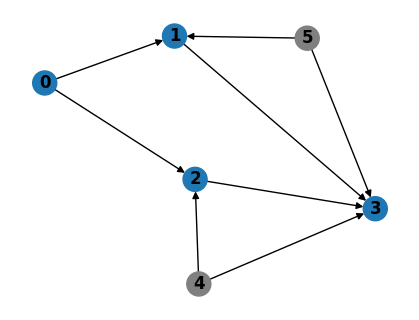

In [16]:
Lambda = get_Lambda([(1,0), (2,0), (3, 1), (3, 2)], 4)
print(f"Lambda is \n {Lambda}")
Gamma = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
highest_l = 1
plot_dag(np.hstack((Lambda, Gamma))) # Latent nodes are grey

In [17]:
from direct_lingam.constraints_to_test import get_constraints_for_l_latents
from itertools import product as c_prod
class IVLiNGAM(ReLVLiNGAM):
    def __init__(self,                 
                 *args,
                 **kwargs):
        """
        Initialize the DiDLiNGAM model.

        Parameters:
        *args: positional arguments
        **kwargs: keyword arguments
        """
        super().__init__(*args, **kwargs)
        self.cumulants = self._estimate_cumulants(self.X)
        cov_matrix = self.cumulants.get(2)
        self.regs = cov_matrix[0, :]/cov_matrix[0, 0]
        
        X_reg = self.X[:, [0, 1, 2, 3]] - np.concatenate([self.X[:, [0]]*r for r in self.regs], axis=1)
        self.red_cumulants = self._estimate_cumulants(np.asfortranarray(X_reg))
        self.roots_1 = self.__get__roots(i=3, j=1)
        self.roots_2 = self.__get__roots(i=3, j=2)
        
        

    def estimate_effect(self):
        """
        Estimate the causal effect using the specified method.

        Parameters:
        method (str): The method to use for effect estimation. Can be "ratio" or "cumulant".

        Raises:
        ValueError: If the specified method is not supported.
        """
        roots = list(c_prod(self.roots_1, self.roots_2))
        diffs = []
        for r in roots:
            diffs.append(np.abs(self.regs[1]*r[0] + self.regs[2]*r[1] - self.regs[3]))
        
        self.causal_effect = roots[np.argmin(diffs)]
        def project(x, a, c):
            return x-a*(np.dot(x, a) - c)/np.dot(a, a)
        self.causal_effect_projected = project(roots[np.argmin(diffs)], self.regs[1:-1], self.regs[-1])
        self.min_norm = project(np.zeros(2), self.regs[1:-1], self.regs[-1])

    def __get__roots(self, i=1, j=0):
        """
        Get the roots of the polynomial equations for the specified nodes.

        Parameters:
        i (int): The index of the first node.
        j (int): The index of the second node.

        Returns:
        numpy.ndarray: The roots of the polynomial equations.
        """
        equations_bij = get_constraints_for_l_latents(1)["equations_bij"]

        eq = equations_bij[0]
        # eq = sum(equations_bij)

        # for eq in equations_bij:
        specify_nodes = {
            sym: symbols(
                sym.name[:2] + "".join(sorted(sym.name[2:].replace("j", str(j)).replace("i", str(i))))
            )
            for sym in reduce(set.union, [eq.free_symbols for eq in equations_bij])
            if str(sym) != "b_ij"
        }
        symbols_to_cumulants = self._form_symbol_to_cumulant_dict(self.red_cumulants, [i, j], scale_partly=False)
        estimated_coeffs = [float(coeff.subs(specify_nodes).subs(symbols_to_cumulants)) for coeff in eq.all_coeffs()]
        roots = np.polynomial.Polynomial(estimated_coeffs[::-1]).roots().astype(np.float64)                    
        return roots

In [18]:
import concurrent.futures


reps = 20
seeds_df = []
parameter_sets = list(range(2*reps, 4*reps))

def run_experiment(seed):
    # run the experiment using the given parameters
        # Set the random seed
    noise_distribution = 'gamma'
    samples_sizes = [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
    n_max = int(max(samples_sizes))
    # p, q = Lambda.shape[0], Lambda.shape[1]+Gamma.shape[1]

    np.random.seed(seed)
    X, true_B = simulate_data(n_max, noise_distribution=noise_distribution, Lambda=Lambda, Gamma=Gamma, permute_order=False)
    causal_effect_true = [true_B[3, 1], true_B[3, 2]]
    
    # Perform the experiment
    causal_effect_estimates_cumulant_1, causal_effect_estimates_cumulant_2 =  [], []
    causal_effect_estimates_cumulant_projected_1, causal_effect_estimates_cumulant_projected_2 = [], []
    dist_to_line = []
    causal_effect_estimate_min_norm_1, causal_effect_estimate_min_norm_2 = [], []
    
    for n in samples_sizes:
        X_sample = X[:int(n), :]
        X_sample = np.asfortranarray(X_sample)
        
        iv_model = IVLiNGAM(X_sample, highest_l = 1)
        iv_model.estimate_effect()
        causal_effect_estimate_cumulant = iv_model.causal_effect
        causal_effect_estimates_cumulant_1.append(causal_effect_estimate_cumulant[0])
        causal_effect_estimates_cumulant_2.append(causal_effect_estimate_cumulant[1])
        causal_effect_estimate_cumulant_projected = iv_model.causal_effect_projected
        causal_effect_estimates_cumulant_projected_1.append(causal_effect_estimate_cumulant_projected[0])
        causal_effect_estimates_cumulant_projected_2.append(causal_effect_estimate_cumulant_projected[1])
        causal_effect_estimate_min_norm = iv_model.min_norm
        causal_effect_estimate_min_norm_1.append(causal_effect_estimate_min_norm[0])
        causal_effect_estimate_min_norm_2.append(causal_effect_estimate_min_norm[1])
        
        a = iv_model.regs[1:-1]
        c = iv_model.regs[-1]
        dist_to_line.append((np.dot(causal_effect_true, a) - c)/np.dot(a, a))
    # Create a DataFrame for the current seed
    seed_df = pd.DataFrame({
        'Seed': [seed] * len(samples_sizes),
        'Sample Size': samples_sizes,
        'True Effect 1': [causal_effect_true[0]] * len(samples_sizes),
        'True Effect 2': [causal_effect_true[1]] * len(samples_sizes),
        'Causal Effect Estimate 1 (Cumulant)': causal_effect_estimates_cumulant_1,
        'Causal Effect Estimate 2 (Cumulant)': causal_effect_estimates_cumulant_2,
        'Causal Effect Estimate 1 (Cumulant Projected)': causal_effect_estimates_cumulant_projected_1,
        'Causal Effect Estimate 2 (Cumulant Projected)': causal_effect_estimates_cumulant_projected_2,
        'Causal Effect Estimate 1 (Min Norm)': causal_effect_estimate_min_norm_1,
        'Causal Effect Estimate 2 (Min Norm)': causal_effect_estimate_min_norm_2,
        'Distance to Line': dist_to_line
    })
    return seed_df


# create a list to store the results


# create a thread pool executor
with concurrent.futures.ThreadPoolExecutor() as executor:
    # submit each experiment to the executor
    print(f"Using {executor._max_workers} processes")
    futures = [executor.submit(run_experiment, params) for params in parameter_sets]

    # wait for all experiments to complete and store the results
    for future in concurrent.futures.as_completed(futures):
        seeds_df.append(future.result())

# process the results as needed
results_df = pd.concat(seeds_df, ignore_index=True)

Using 12 processes


/var/folders/nd/nn8th6r16cq6sytrzw1nw_9w0000gn/T/ipykernel_6042/3876619644.py:73: ComplexWarning: Casting complex values to real discards the imaginary part
  roots = np.polynomial.Polynomial(estimated_coeffs[::-1]).roots().astype(np.float64)


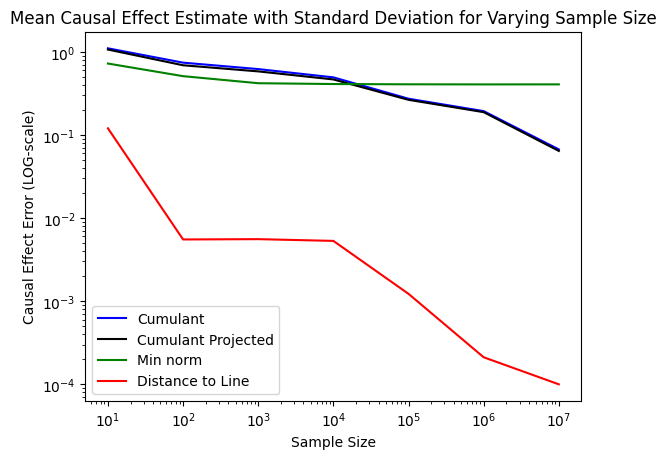

In [19]:
import matplotlib.pyplot as plt

results_df["Cumulant Error 1"] = np.abs((results_df['Causal Effect Estimate 1 (Cumulant)'] - results_df["True Effect 1"])/results_df["True Effect 1"])  # Calculate the error
results_df["Cumulant Error 2"] = np.abs((results_df['Causal Effect Estimate 2 (Cumulant)'] - results_df["True Effect 2"])/results_df["True Effect 2"])  # Calculate the error
results_df["Cumulant Error"] = np.mean([results_df["Cumulant Error 1"], results_df["Cumulant Error 2"]], axis=0)
results_df["Min Norm Error 1"] = np.abs((results_df['Causal Effect Estimate 1 (Min Norm)'] - results_df["True Effect 1"])/results_df["True Effect 1"])  # Calculate the error
results_df["Min Norm Error 2"] = np.abs((results_df['Causal Effect Estimate 2 (Min Norm)'] - results_df["True Effect 2"])/results_df["True Effect 2"])  # Calculate the error
results_df["Min Norm Error"] = np.mean([results_df["Min Norm Error 1"], results_df["Min Norm Error 2"]], axis=0)
results_df["Cumulant Projected Error 1"] = np.abs((results_df['Causal Effect Estimate 1 (Cumulant Projected)'] - results_df["True Effect 1"])/results_df["True Effect 1"])  # Calculate the error
results_df["Cumulant Projected Error 2"] = np.abs((results_df['Causal Effect Estimate 2 (Cumulant Projected)'] - results_df["True Effect 2"])/results_df["True Effect 2"])  # Calculate the error
results_df["Cumulant Projected Error"] = np.mean([results_df["Cumulant Projected Error 1"], results_df["Cumulant Projected Error 2"]], axis=0)


# results_df["Ratio Test Error"] = np.abs((results_df['Causal Effect Estimate (Ratio Test)'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error
# results_df["Ratio Test After Matching Error"] = np.abs((results_df['Causal Effect Estimate (Ratio Test After Matching)'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error
# results_df["Cumulant Error With True Matrix"] = np.abs((results_df['Causal Effect Estimate (Cumulant With True Matrix)'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error
# results_df["CM Error"] = np.abs((results_df['Cross Moment'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error

# # Group the results by sample size and calculate the mean
mean_results = results_df.groupby('Sample Size').mean()
mean_sd = results_df.groupby('Sample Size').std()

# Plot the mean results
plt.yscale('log')
plt.xscale('log')
plt.plot(mean_results.index, mean_results["Cumulant Error"],
         label='Cumulant',
         color = "blue")

plt.plot(mean_results.index, mean_results["Cumulant Projected Error"],
         label='Cumulant Projected',
         color = "black")
plt.plot(mean_results.index, np.abs(mean_results["Min Norm Error"]),
         label='Min norm',
         color = "green")
plt.plot(mean_results.index, np.abs(mean_results["Distance to Line"]),
         label='Distance to Line',
         color = "red")

# plt.plot(mean_results.index, mean_results["Cumulant Error 1"],
#          label='Cumulant 1',
#          color = "blue")

# plt.plot(mean_results.index, mean_results["Cumulant Error 2"],
#          label='Cumulant 2',
#          color = "black")

# plt.plot(mean_results.index, mean_results["Cumulant Projected Error 1"],
#          label='Cumulant projected 1',
#          color = "red")

# plt.plot(mean_results.index, mean_results["Cumulant Projected Error 2"],
#          label='Cumulant projected 2',
#          color = "green")

# plt.plot(mean_results.index, mean_results["Ratio Test Error"],
#          label='Ratio Test',
#          color = "red")

# plt.plot(mean_results.index, mean_results["Ratio Test After Matching Error"],
#          label='Ratio Test After Matching Error',
#          color = "green")

# plt.plot(mean_results.index, mean_results["CM Error"],
#          label='CM',
#          color = "black")

# plt.plot(mean_results.index, mean_results["Match Error"],
#          label='Match',
#          color = "pink")

# plt.plot(mean_results.index, mean_results["Root Error"],
#          label='Roots',
#          color = "purple")

# plt.plot(mean_results.index, mean_results["Cumulant Error With True Matrix"],
#          label='Cum_true_matrix',
#          color = "grey")

# plt.fill_between(mean_results.index,
#                  mean_results['Cumulant Error'] + mean_sd['Cumulant Error'],
#                  mean_results['Cumulant Error'] - mean_sd['Cumulant Error'],
#                  color = "blue",
#                  alpha=0.2)


# plt.fill_between(mean_results.index, 
#                  mean_results['Ratio Test Error'] + mean_sd['Ratio Test Error'], 
#                  mean_results['Ratio Test Error'] - mean_sd['Ratio Test Error'],
#                  alpha=0.2, 
#                  color = "red")


# plt.fill_between(mean_results.index,
#                  mean_results['Latent Factor Error'] + mean_sd['Latent Factor Error'],
#                  mean_results['Latent Factor Error'] - mean_sd['Latent Factor Error'],
#                  alpha=0.2,
#                  color = "green")


# plt.fill_between(mean_results.index, 
#                  mean_results['CM Error'] + mean_sd['CM Error'], 
#                  mean_results['CM Error'] - mean_sd['CM Error'],
#                  alpha=0.2, 
#                  color = "black")



plt.xlabel('Sample Size')
plt.ylabel('Causal Effect Error (LOG-scale)')
plt.legend()
plt.title('Mean Causal Effect Estimate with Standard Deviation for Varying Sample Size')
plt.show()